In [132]:
import numpy as np
import matplotlib.pyplot as plot

from sklearn import linear_model

import time 
from math import ceil

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [216]:
DIM = 10

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_v = np.vectorize(sigmoid)
    
def choose_label(r, p):
    if r < p:
        return 1
    else:
        return 0
    
def generate_data(m):
    w = np.random.rand(DIM)
    w /= np.linalg.norm(w)
    
    X = np.random.normal(0, 1, (m, DIM))
    
    ps = sigmoid_v(w @ X.T)
    choose_labels = np.vectorize(choose_label)
    y = choose_labels(np.random.rand(m), ps)
    
    # returns the true w as well as X, Y data
    return w, X, y

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [217]:
RANDOM_STATE=101

def logistic_regression(X, y):
    classifier = linear_model.LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    classifier.fit(X, y)
    
    return classifier.coef_[0]

# run example
w, X, y = generate_data(1000)
print(w)
print(logistic_regression(X, y))

[0.29622056 0.3162851  0.32021024 0.08816645 0.24607478 0.30141635
 0.36973375 0.26476243 0.43623296 0.39166719]
[0.25893271 0.31102916 0.30888365 0.02148039 0.3849368  0.23721259
 0.41528687 0.23343693 0.45271473 0.27962368]


## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

**Answer:** 

The gradient component function is:
$$\frac{\delta L_i(w)}{\delta w_j} = \frac{1}{2}2\left(\sigma(w \cdot x) - y_i \right)\left(-\left(\frac{1}{1 + e^{-w \cdot x}}\right)^2\right)\left(\frac{\delta(-w \cdot x)}{\delta w_j}e^{-w \cdot x}\right) = \left( \sigma(w \cdot x) - y_i \right)\sigma^2(w \cdot x)e^{-w \cdot x}x_j$$
Thus the overall gradient function is:
$$\nabla L_i(w) = \left( \sigma(w \cdot x) - y_i \right)\sigma^2(w \cdot x)e^{-w \cdot x}x$$

In [287]:
def gradient(w, x, y):
    wx = w.dot(x)
    s_wx = sigmoid(wx)
    return ((s_wx - y)*(s_wx**2)*np.exp(-wx)) * x

# returns the last w
def gradient_descent(X, y, max_iter=1000, eta=0.01):
    w_old = np.zeros(DIM)
    w_new = np.zeros(DIM)
    for _ in range(max_iter):
        for i in range(len(X)):
            w_new -= eta*gradient(w_old, X[i], y[i])/len(X)
        w_old = w_new
    return w_new

# r = np.arange(-10, 10, .2)
# plot.plot(r, [gradient(np.array([w]), np.array([2]), 0) for w in r])

assert(-(gradient(np.array([1]), np.array([10]), 1)) < 0.1**7)
assert((gradient(np.array([1]), np.array([10]), 0)) > 0)

# run example
w, X, y = generate_data(1000)
print(w)
print(gradient_descent(X, y))
# print(gradient_descent_average(X, y))

[0.189047   0.3016165  0.45807953 0.3927659  0.51177062 0.09760931
 0.00211455 0.3698466  0.00812684 0.31763665]
[0.03165418 0.10479618 0.1447665  0.11343775 0.17554474 0.00467112
 0.0524703  0.14880553 0.02768792 0.16845625]


## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [292]:
def stochastic_gradient_descent(X, y, max_iter=1000, eta=0.01):
    w = np.zeros(DIM)
    w_bar = np.zeros(DIM)
    
    # let's split in blocks of size len(X)
    # so we don't repeat examples
    n_blocks = ceil(max_iter/len(X))
    
    for block_i in range(n_blocks):
        sample_size = min(max_iter - block_i * len(X), len(X))
        js = np.random.choice(len(X), sample_size, replace=False)
        for j in js:
            w -= eta*gradient(w, X[j], y[j])
            w_bar += w/max_iter
    return w_bar
            
w, X, y = generate_data(1000)
print(w)
print(stochastic_gradient_descent(X, y, eta=0.08))

[0.32829617 0.49219168 0.05266572 0.43466268 0.03865111 0.3307226
 0.26632049 0.46492193 0.2033189  0.1377488 ]
[0.20450183 0.34360996 0.01451132 0.32023416 0.02054103 0.14948671
 0.20246246 0.4046655  0.14353273 0.06546897]


## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

{'logistic_regression': 0.26987296600054833, 'gradient_descent': 143.59353668999665, 'stochastic_gradient_descent': 1.0682990639998025, 'gradient_descent_eta0.8': 140.91589786500026, 'stochastic_gradient_descent_eta0.8': 1.085404879005182}


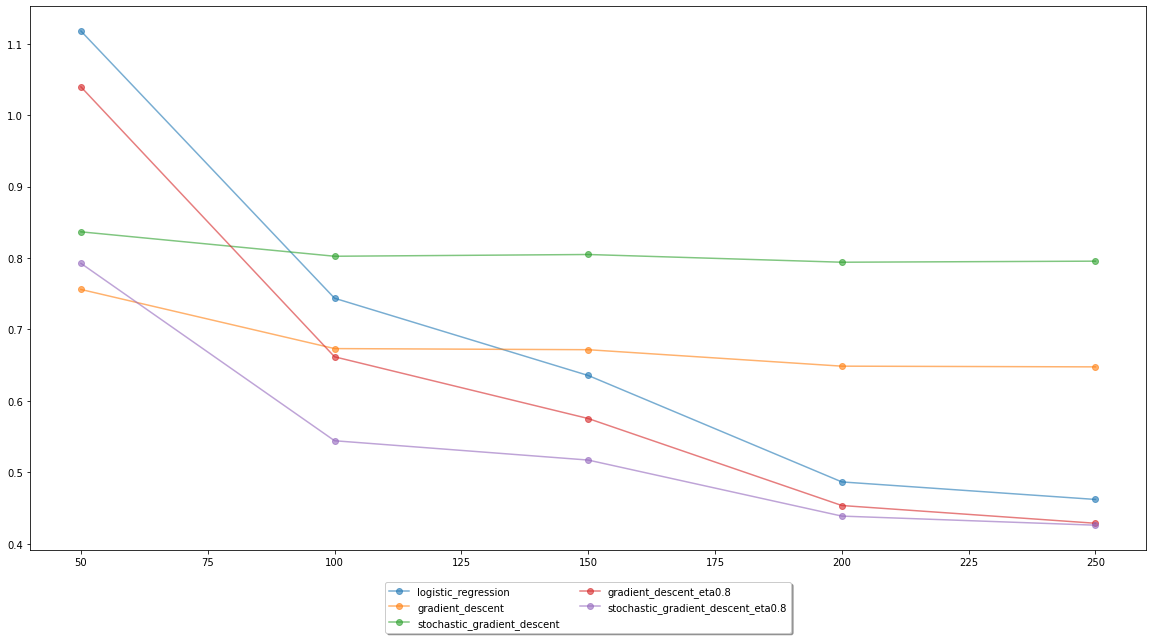

In [293]:
from functools import partial

ms = np.arange(50, 300, 50)
n_runs = 20
algorithms = {
    'logistic_regression': logistic_regression,
    'gradient_descent': gradient_descent,
    'stochastic_gradient_descent': stochastic_gradient_descent,
    # adding the higher-eta versions; these converge quicker, so I thought it was interesting to see
    'gradient_descent_eta0.8': partial(gradient_descent, eta=0.08),
    'stochastic_gradient_descent_eta0.8': partial(stochastic_gradient_descent, eta=0.08),
}
times = {a: 0 for a in algorithms.keys()}
deltas = {a: [] for a in algorithms.keys()}
    
for m in ms:
    average_deltas = {a: 0 for a in algorithms.keys()}
    
    for _ in range(n_runs):
        w_star, X, y = generate_data(m)
        
        for algorithm, kernel in algorithms.items():
            start_time = time.process_time()
        
            w = kernel(X, y)
            delta = np.linalg.norm(w_star - w)
            average_deltas[algorithm] += delta/n_runs
            
            times[algorithm] += time.process_time() - start_time
        
    for algorithm, average_delta in average_deltas.items():
        deltas[algorithm].append(average_delta)
        
for algorithm, deltas in deltas.items():
    plot.plot(ms, deltas, label=algorithm, alpha=0.6, marker="o")
    
plot.rcParams["figure.figsize"] = (20,10)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

# gradient descent is much slower, which makes sense since it uses the whole data set at every step so it's O(m*n*iter) vs O(n*iter) of the SGD
print(times)

# You can see the monotonicity over sample size, especially for the higher eta, which track the logistic regression method
# SGD has overall more error than regular GD
plot.show()

# Problem 2

In [272]:
from sklearn import datasets
from sklearn import tree, ensemble
from sklearn.model_selection import cross_val_score

In [270]:
cancer = datasets.load_breast_cancer()



For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

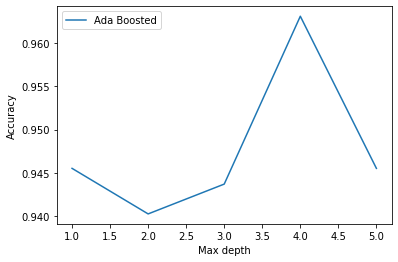

In [273]:
RANDOM_SEED=101

max_depths = np.arange(1, 6)
cross_validated_accuracies = []

for max_depth in max_depths:
    base_classifier = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_SEED)
    classifier = ensemble.AdaBoostClassifier(base_classifier, n_estimators=10, learning_rate=1, random_state=RANDOM_SEED)
    
    cross_validated_accuracy = cross_val_score(classifier, cancer.data, cancer.target, cv=10, n_jobs=-1).mean()
    cross_validated_accuracies.append(cross_validated_accuracy)
    
plot.xlabel("Max depth")
plot.ylabel("Accuracy")

line, = plot.plot(max_depths, cross_validated_accuracies)
line.set_label("Ada Boosted")
    
plot.legend()
plot.show()